
<center><h2>Customer Segmentation / Clustering</h2></center>

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

- **Customers**,and **Transactions** contains complementary information.  
- So, we gather all the required information (Customers,and Transactions data) into a single dataset for analysis. 
- It helps us to perform perform customer segmentation using clustering techniques,and draw conclusions that are important for the business.  

In [30]:
# Loading the datasets
customers_data = pd.read_csv("Customers.csv")
transactions_data = pd.read_csv("Transactions.csv")

# Merging Transactions with Customers
dataset = pd.merge(transactions_data, customers_data, on="CustomerID", how="left")

# Converting date columns to datetime format for analysis
dataset["TransactionDate"] = pd.to_datetime(dataset["TransactionDate"])
dataset["SignupDate"] = pd.to_datetime(dataset["SignupDate"])

# Displaying the first few rows of the merged dataset
print(dataset.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe 2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia 2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe 2024-04-04  
3      601.36  300.68  Travis Campbell  South America 2024-04-11  
4      902.04  300.68    Timothy Perez         Europe 2022-03-15  


In [31]:
dataset.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


What is **TotalValue**?  
In the dataset, **TotalValue** represents the total monetary value of a specific transaction.  
It is calculated as:  

<center><h5>TotalValue = Price × Quantity</h5></center>  

Where:  
- **Price**: The price of a single unit of the product involved in the transaction.  
- **Quantity**: The number of units of the product purchased in that transaction.  


In [32]:
### Verifying and Correcting 'TotalValue' Field

In [33]:
# Validating 'TotalValue'
incorrect_totalvalue = dataset[dataset["TotalValue"] != dataset["Price"] * dataset["Quantity"]]
print(f"Number of incorrect 'TotalValue' rows: {len(incorrect_totalvalue)}")
if len(incorrect_totalvalue) == 0:
    print("All 'TotalValue' calculations are correct.")

Number of incorrect 'TotalValue' rows: 88


In [34]:
# Correcting 'TotalValue' based on 'Price' and 'Quantity' for rows with discrepancies
dataset.loc[dataset["TotalValue"] != dataset["Price"] * dataset["Quantity"], "TotalValue"] = (
    dataset["Price"] * dataset["Quantity"]
)

# Verifying corrections
incorrect_totalvalue_after_correction = dataset[dataset["TotalValue"] != dataset["Price"] * dataset["Quantity"]]

# Displaying the number of discrepancies after correction
print(f"Number of incorrect 'TotalValue' rows after correction: {len(incorrect_totalvalue_after_correction)}")

# Confirming that the incorrect values has been corrected
if len(incorrect_totalvalue_after_correction) == 0:
    print("All discrepancies in 'TotalValue' have been successfully corrected.")


Number of incorrect 'TotalValue' rows after correction: 0
All discrepancies in 'TotalValue' have been successfully corrected.


### Analyzing the Unique Region Data

In [35]:
# Displaying all unique regions
unique_regions = dataset["Region"].unique()

# Converting to a DataFrame for a better readability
unique_regions_df = pd.DataFrame(unique_regions, columns=["Region"])

# Displaying the total number of unique regions
print(f"Total Unique Regions: {len(unique_regions)}")

# Displaying the region names
print("\nList of Unique Regions:")
print(unique_regions_df)

Total Unique Regions: 4

List of Unique Regions:
          Region
0         Europe
1           Asia
2  South America
3  North America


### Imputation handling

In [36]:
# Checking for missing values in the dataset
missing_values = dataset.isnull().sum()

# Displaying columns with missing values
print("Missing values in the dataset:")
print(missing_values[missing_values > 0])

# Total number of missing values across all columns
total_missing = dataset.isnull().sum().sum()
print(f"\nTotal number of missing values in the dataset: {total_missing}")


Missing values in the dataset:
Series([], dtype: int64)

Total number of missing values in the dataset: 0


- There is no missing values in this dataset.

### Inspecting Column Data Types

In [37]:
# Check and fix data types
print("\nColumn data types:")
print(dataset.dtypes)


Column data types:
TransactionID              object
CustomerID                 object
ProductID                  object
TransactionDate    datetime64[ns]
Quantity                    int64
TotalValue                float64
Price                     float64
CustomerName               object
Region                     object
SignupDate         datetime64[ns]
dtype: object


### Identifying Outliers (Extreme Values)

In [38]:
# 3. Analyzing the outliers in numerical columns
numerical_cols = ["Price", "Quantity", "TotalValue"]
for col in numerical_cols:
    print(f"\nSummary statistics for {col}:")
    print(dataset[col].describe())


Summary statistics for Price:
count    1000.00000
mean      272.55407
std       140.73639
min        16.08000
25%       147.95000
50%       299.93000
75%       404.40000
max       497.76000
Name: Price, dtype: float64

Summary statistics for Quantity:
count    1000.000000
mean        2.537000
std         1.117981
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Quantity, dtype: float64

Summary statistics for TotalValue:
count    1000.000000
mean      689.995560
std       493.144478
min        16.080000
25%       295.295000
50%       588.880000
75%      1011.660000
max      1991.040000
Name: TotalValue, dtype: float64


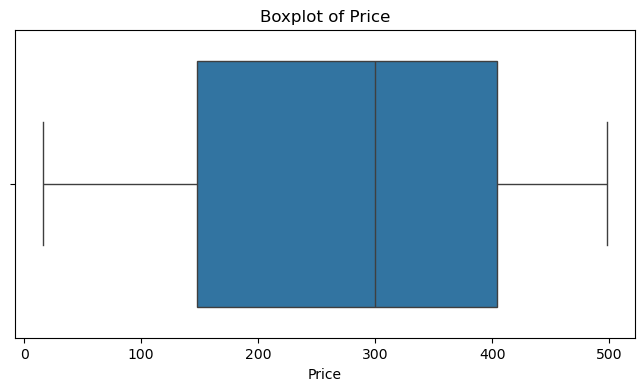

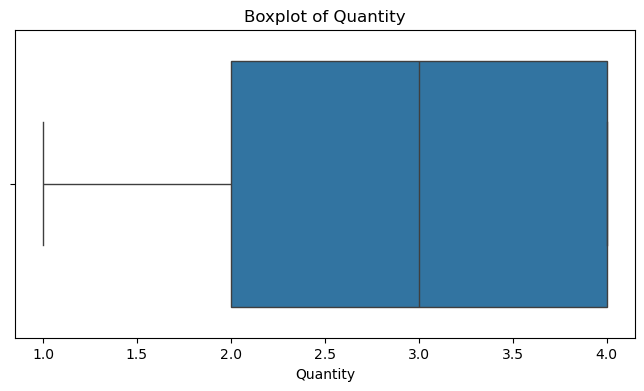

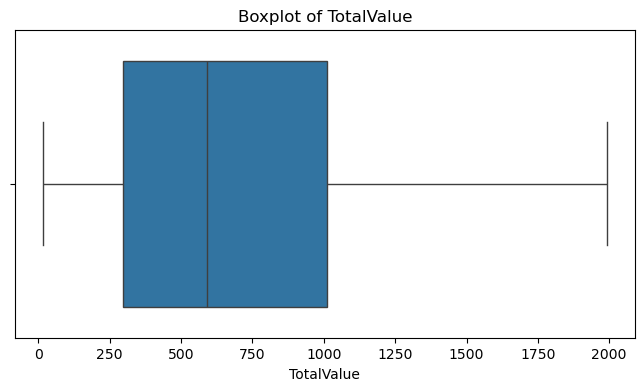

In [39]:
# Visualizing the outliers using boxplots
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=dataset, x=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

- **Price**: The values are distributed between 16 and 498.    
- **Quantity**: The range of Quantity is well-defined between 1 and 4.    
- **TotalValue**: The values range from about 16 to about 1991.
  
All three numerical columns (Price, Quantity, TotalValue) are clean and does not have any outliers.  

In [40]:
dataset.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [43]:
# Dropping the columns that are not needed for clustering
dataset_cleaned = dataset.drop(columns=["TransactionID", "ProductID","CustomerName"])

print("Cleaned Dataset:")
dataset_cleaned.head()

Cleaned Dataset:


,CustomerID,TransactionDate,Quantity,TotalValue,Price,Region,SignupDate
0,C0199,2024-08-25 12:38:23,1,300.68,300.68,Europe,2022-12-03
1,C0146,2024-05-27 22:23:54,1,300.68,300.68,Asia,2024-09-04
2,C0127,2024-04-25 07:38:55,1,300.68,300.68,Europe,2024-04-04
3,C0087,2024-03-26 22:55:37,2,601.36,300.68,South America,2024-04-11
4,C0070,2024-03-21 15:10:10,3,902.04,300.68,Europe,2022-03-15


- **TransactionID** and **ProductID**: Irrelevant for clustering as they are unique to transactions/products.  
- **CustomerName**: Redundant as we are using **CustomerID**.  


### Encoding Categorical Variables

In [47]:
unique_regions = dataset_cleaned["Region"].unique()
print(f"Total Unique Regions: {len(unique_regions)}")
print("\nList of Unique Regions:")
print(unique_regions)

Total Unique Regions: 4

List of Unique Regions:
['Europe' 'Asia' 'South America' 'North America']


In [94]:
data_encoded = pd.get_dummies(dataset_cleaned, columns=["Region"], drop_first=False)
print("\nEncoded Dataset:")
print(data_encoded.head())



Encoded Dataset:
  CustomerID     TransactionDate  Quantity  TotalValue   Price SignupDate  \
0      C0199 2024-08-25 12:38:23         1      300.68  300.68 2022-12-03   
1      C0146 2024-05-27 22:23:54         1      300.68  300.68 2024-09-04   
2      C0127 2024-04-25 07:38:55         1      300.68  300.68 2024-04-04   
3      C0087 2024-03-26 22:55:37         2      601.36  300.68 2024-04-11   
4      C0070 2024-03-21 15:10:10         3      902.04  300.68 2022-03-15   

   Region_Asia  Region_Europe  Region_North America  Region_South America  
0        False           True                 False                 False  
1         True          False                 False                 False  
2        False           True                 False                 False  
3        False          False                 False                  True  
4        False           True                 False                 False  


In [95]:
# Converting boolean columns to the integers
boolean_columns = data_encoded.select_dtypes(include=['bool']).columns
data_encoded[boolean_columns] = data_encoded[boolean_columns].astype(int)
print(data_encoded.dtypes)


CustomerID                      object
TransactionDate         datetime64[ns]
Quantity                         int64
TotalValue                     float64
Price                          float64
SignupDate              datetime64[ns]
Region_Asia                      int64
Region_Europe                    int64
Region_North America             int64
Region_South America             int64
dtype: object


In [96]:
data_encoded.head()

,CustomerID,TransactionDate,Quantity,TotalValue,Price,SignupDate,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0199,2024-08-25 12:38:23,1,300.68,300.68,2022-12-03,0,1,0,0
1,C0146,2024-05-27 22:23:54,1,300.68,300.68,2024-09-04,1,0,0,0
2,C0127,2024-04-25 07:38:55,1,300.68,300.68,2024-04-04,0,1,0,0
3,C0087,2024-03-26 22:55:37,2,601.36,300.68,2024-04-11,0,0,0,1
4,C0070,2024-03-21 15:10:10,3,902.04,300.68,2022-03-15,0,1,0,0


- To make the dataset suitable with clustering algorithms, converting the **Region** into numerical values.
- The dataset now includes numeric columns for Region (e.g., Region_Asia, Region_Europe, Region_North America	Region_South America).

### Feature Selection for Clustering

In [97]:
# Select relevant columns for clustering
features_for_clustering = data_encoded.drop(columns=["CustomerID", "TransactionDate", "SignupDate"])

# Display selected features
print("Selected Features for Clustering:")
print(features_for_clustering.head())


Selected Features for Clustering:
   Quantity  TotalValue   Price  Region_Asia  Region_Europe  \
0         1      300.68  300.68            0              1   
1         1      300.68  300.68            1              0   
2         1      300.68  300.68            0              1   
3         2      601.36  300.68            0              0   
4         3      902.04  300.68            0              1   

   Region_North America  Region_South America  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     1  
4                     0                     0  


### Standardization

In [99]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Convert back to DataFrame for easy interpretation
scaled_df = pd.DataFrame(scaled_features, columns=features_for_clustering.columns)

# Display scaled data
print("Scaled Data (first 5 rows):")
print(scaled_df.head())

Scaled Data (first 5 rows):
   Quantity  TotalValue     Price  Region_Asia  Region_Europe  \
0 -1.375488   -0.789850  0.199948    -0.527989       1.809283   
1 -1.375488   -0.789850  0.199948     1.893979      -0.552705   
2 -1.375488   -0.789850  0.199948    -0.527989       1.809283   
3 -0.480571   -0.179825  0.199948    -0.527989      -0.552705   
4  0.414347    0.430200  0.199948    -0.527989       1.809283   

   Region_North America  Region_South America  
0             -0.568112             -0.660895  
1             -0.568112             -0.660895  
2             -0.568112             -0.660895  
3             -0.568112              1.513101  
4             -0.568112             -0.660895  


##### Why We Had Scaled the Features?  
It standardizes the range of numerical data and ensures:  
- All the features contribute equally to the model.  
- It avoids the dominance of features with larger ranges over smaller ones.  

**Eg:**  
- **TotalValue** might range from 100 to 10,000.  
- **Quantity** might range from 1 to 10.  

Scaling standardizes the data, giving all features equal importance by bringing them to the same scale (mean of 0 and standard deviation of 1).  



<center><h2>K-Means Clustering</h2></center>

### Determining the Optimal Number of Clusters

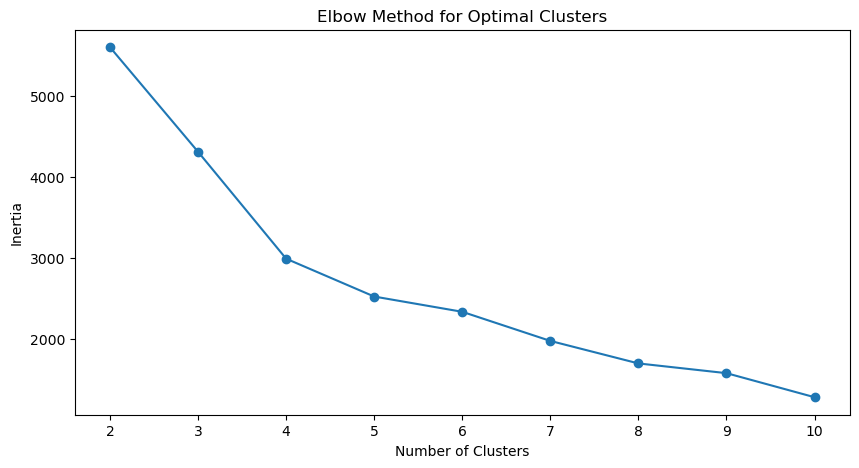

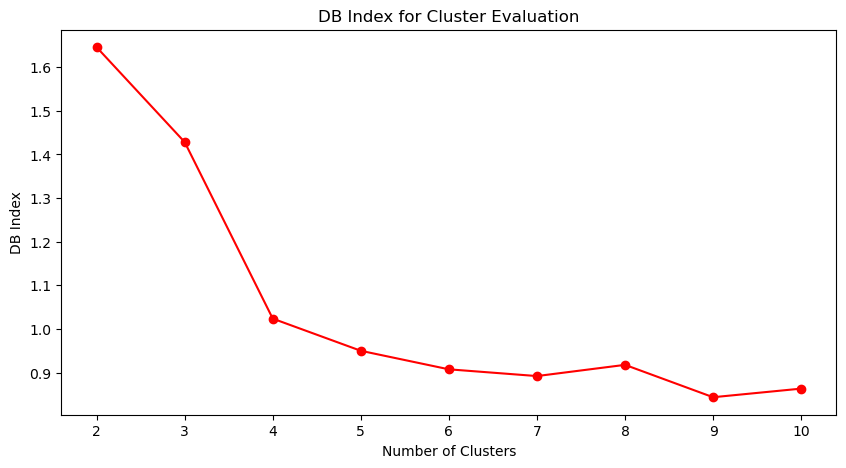

In [100]:
inertia = []
db_index = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(scaled_features, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot DB Index
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db_index, marker='o', color='red')
plt.title('DB Index for Cluster Evaluation')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()


 **Elbow Method Analysis**
- The **elbow point** appears around **k = 4**, where the rate of decrease in inertia slows down significantly.  
- This suggests that **4 clusters** might provide a good balance between cluster compactness and simplicity.  

 **DB Index Analysis**
- The **DB Index** decreases sharply and stabilizes after **k = 4**.  
- Since a lower **DB Index** indicates better clustering, **k = 4** seems to be the optimal choice here as well.  


### Perform Clustering

In [111]:
# Final clustering with k = 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_encoded['Cluster'] = kmeans.fit_predict(scaled_features)

# Display dataset with cluster labels
print("Dataset with Cluster Labels:")
print(data_encoded.head())


Dataset with Cluster Labels:
  CustomerID     TransactionDate  Quantity  TotalValue   Price SignupDate  \
0      C0199 2024-08-25 12:38:23         1      300.68  300.68 2022-12-03   
1      C0146 2024-05-27 22:23:54         1      300.68  300.68 2024-09-04   
2      C0127 2024-04-25 07:38:55         1      300.68  300.68 2024-04-04   
3      C0087 2024-03-26 22:55:37         2      601.36  300.68 2024-04-11   
4      C0070 2024-03-21 15:10:10         3      902.04  300.68 2022-03-15   

   Region_Asia  Region_Europe  Region_North America  Region_South America  \
0            0              1                     0                     0   
1            1              0                     0                     0   
2            0              1                     0                     0   
3            0              0                     0                     1   
4            0              1                     0                     0   

   Cluster  
0        3  
1        0  
2     

- Segment customers into clusters using **K-Means**.
- The dataset now includes a Cluster column.

### Evaluate Clustering

In [110]:
# Compute final DB Index
final_db_index = davies_bouldin_score(scaled_features, data_encoded["Cluster"])
print(f"Final DB Index: {final_db_index}")

# Summarize cluster characteristics
cluster_summary = data_encoded.groupby("Cluster").agg(
    AverageTotalValue=("TotalValue", "mean"),
    AverageQuantity=("Quantity", "mean"),
    AveragePrice=("Price", "mean"),
    ClusterSize=("Cluster", "count")
)
print("Cluster Summary:")
print(cluster_summary)


Final DB Index: 1.0236095510632044
Cluster Summary:
         AverageTotalValue  AverageQuantity  AveragePrice  ClusterSize
Cluster                                                               
0               697.591606         2.568807    271.284541          218
1               721.554474         2.595395    277.012566          304
2               624.235246         2.430328    265.242090          244
3               710.489872         2.542735    275.569017          234


### Clustering Evaluation and Insights

#### **Davies-Bouldin Index (DBI)**
- We are using the **Davies-Bouldin Index (DBI)** to evaluate the quality of clustering.  
- A **lower DBI score** indicates better clustering.

#### **Cluster Insights**

**Cluster 0 (218 Customers):**  
- Average **Total Value**: 697.59 dollars.  
- Customers purchase slightly lower-priced products.  
- Average **quantity purchased**: 2.57 items per transaction.  

**Cluster 1 (304 Customers):**  
- **Largest cluster**.  
- Highest spending customers with an **Average Total Value**: 721.55 dollars.  
- Average **quantity purchased**: 2.60 items.  
- Tend to buy **higher-priced products**: 277.01 dollars.  

**Cluster 2 (244 Customers):**  
- Lowest spending customers with an **Average Total Value**: 624.23 dollars.  
- Transactions involve **fewer quantities**: 2.43 items.  
- Products purchased are **lower-priced**: 265.24 dollars.  

**Cluster 3 (234 Customers):**  
- Similar spending behavior to **Cluster 1** with an **Average Total Value**: 710.49 dollars.  
- Average **quantity purchased**: 2.54 items.  
- Spend on **mid-range products**: 275.57 dollars.  


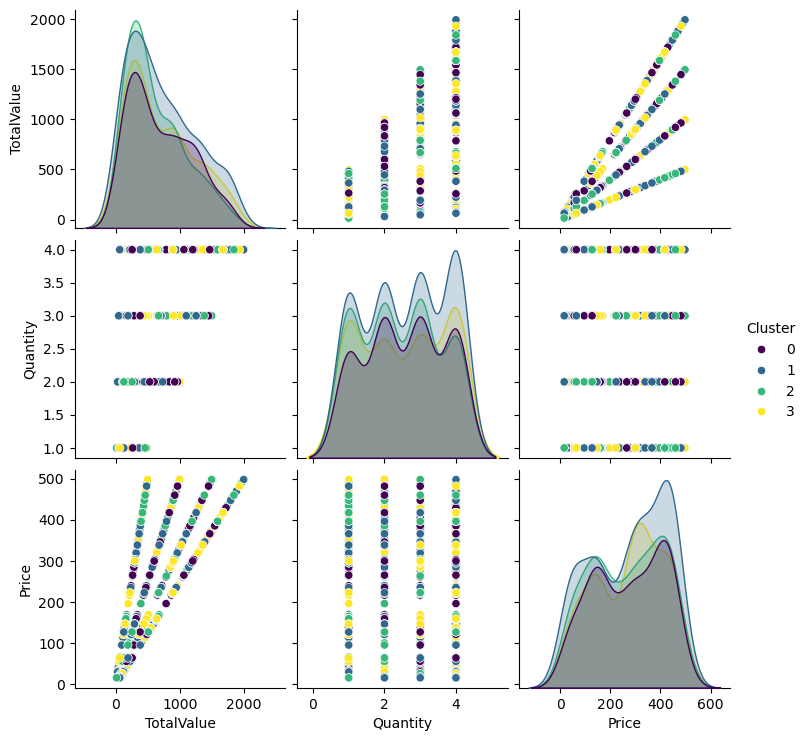

In [106]:
import seaborn as sns

# Pairplot to visualize clusters
sns.pairplot(data_encoded, vars=["TotalValue", "Quantity", "Price"], hue="Cluster", palette="viridis")
plt.show()


- The pair plot visualizes the clusters based on the features **TotalValue**, **Quantity**, and **Price**, allowing us to see how these features interact within and across clusters


Actionable Insights for Marketing:
- For personalized promotions or premium product campaigns,**Focus on Cluster 1 and Cluster 3**  
- To increase the spending.**Design loyalty programs for Cluster 0**   
- To engage Cluster 2 customers **Offer discounts or bundled deals**   

Additional Analysis:
- **Investigate regional patterns** within each cluster to refine the strategies.  
- **Analyze time-based behavior** (e.g., transaction frequency over months).  



<center><h2>Hierarchical Clustering</h2></center>

### Plotting  the Dendrogram

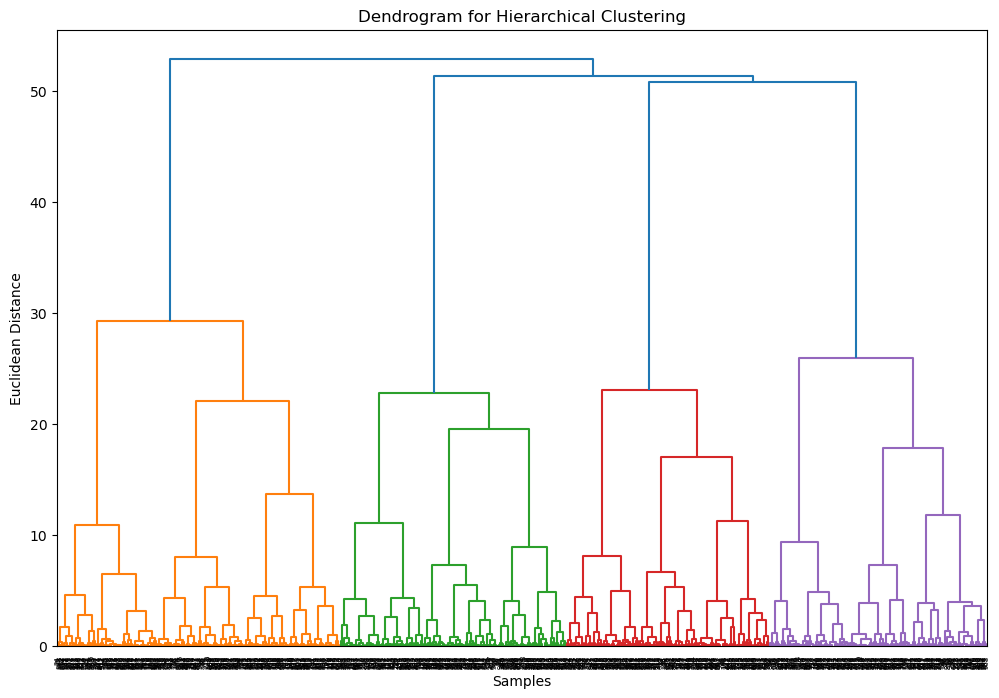

In [114]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(scaled_features, method="ward"))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()


- To determine the number of clusters and Visualizing the hierarchical clustering structure.
- Based on the dendrogram, we will apply Agglomerative Clustering with 4 clusters.

### Applying Agglomerative Clustering

In [116]:
from sklearn.cluster import AgglomerativeClustering

# number of clusters based on dendrogram analysis
n_clusters = 4  
hc = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")

# Fit and predict cluster labels
scaled_df['Cluster'] = hc.fit_predict(scaled_features)

# Displaying the dataset with cluster labels
print("Dataset with Cluster Labels:")
print(scaled_df.head())


Dataset with Cluster Labels:
   Quantity  TotalValue     Price  Region_Asia  Region_Europe  \
0 -1.375488   -0.789850  0.199948    -0.527989       1.809283   
1 -1.375488   -0.789850  0.199948     1.893979      -0.552705   
2 -1.375488   -0.789850  0.199948    -0.527989       1.809283   
3 -0.480571   -0.179825  0.199948    -0.527989      -0.552705   
4  0.414347    0.430200  0.199948    -0.527989       1.809283   

   Region_North America  Region_South America  Cluster  
0             -0.568112             -0.660895        1  
1             -0.568112             -0.660895        3  
2             -0.568112             -0.660895        1  
3             -0.568112              1.513101        0  
4             -0.568112             -0.660895        1  


- Segment customers into clusters using  Agglomerative Clustering.
- The dataset now includes a Cluster column

### Evaluate Clustering

In [120]:
from sklearn.metrics import davies_bouldin_score

# Compute the Davies-Bouldin Index
final_db_index = davies_bouldin_score(scaled_features, scaled_df["Cluster"])
print(f"Final DB Index: {final_db_index}")

cluster_summary = scaled_df.groupby("Cluster").agg(
    AverageQuantity=("Quantity", "mean"),
    AverageTotalValue=("TotalValue", "mean"),
    AveragePrice=("Price", "mean"),
    ClusterSize=("Cluster", "count")
)

print("Cluster Summary:")
print(cluster_summary)


Final DB Index: 1.0236095510632044
Cluster Summary:
         AverageQuantity  AverageTotalValue  AveragePrice  ClusterSize
Cluster                                                               
0               0.052258           0.064027      0.031696          304
1               0.005132           0.041579      0.021433          234
2              -0.095463          -0.133416     -0.051981          244
3               0.028465           0.015411     -0.009025          218


Insights:

**Cluster 0 (304 Customers):**  
- This cluster has the largest customer base.  
- Customers exhibit slightly higher-than-average behavior across all metrics, making this a valuable segment for general engagement strategies.  

**Cluster 1 (234 Customers):**  
- Customers in this cluster have slightly above-average spending behavior but less pronounced compared to Cluster 0.  
- This could be a segment for personalized campaigns targeting increased spending.  

**Cluster 2 (244 Customers):**  
- These are the low spenders with below-average Quantity, TotalValue, and Price.  
- Likely to benefit from discounts, bundle offers, or campaigns targeting increased purchase frequency.  

**Cluster 3 (218 Customers):**  
- A smaller segment with almost average behavior for Quantity and TotalValue but slightly below-average Price.  
- Could represent a segment preferring moderately priced products or a mix of low and medium spenders.  


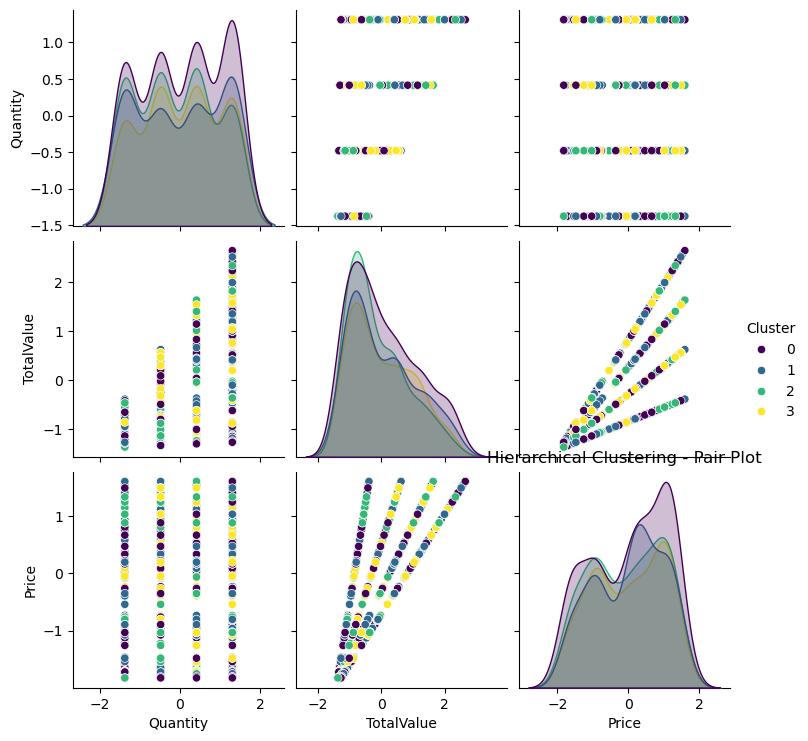

In [118]:
import seaborn as sns

# Visualize clusters
sns.pairplot(scaled_df, vars=["Quantity", "TotalValue", "Price"], hue="Cluster", palette="viridis")
plt.title("Hierarchical Clustering - Pair Plot")
plt.show()


- The pair plot visualizes how the clusters formed using hierarchical clustering differ across the features **Quantity**, **TotalValue**, and **Price**.

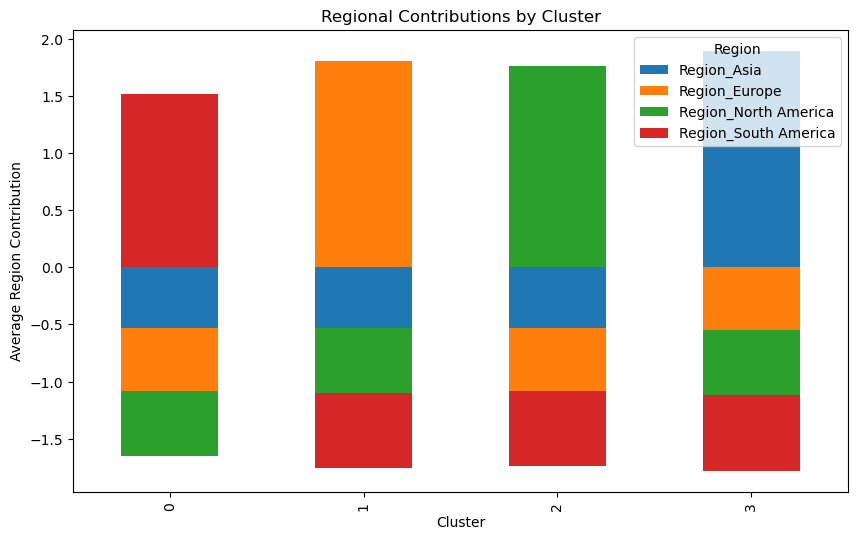

In [119]:
# Summarize regional contributions by cluster
region_summary = scaled_df.groupby("Cluster").mean()

# Stacked bar plot for regions
region_summary[['Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America']].plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Regional Contributions by Cluster")
plt.ylabel("Average Region Contribution")
plt.xlabel("Cluster")
plt.legend(title="Region")
plt.show()


- This visualization shows how the regions (Asia, Europe, North America, South America) contribute to each cluster.


<center><h2>DBSCAN Clustering</h2></center>

In [122]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Using the scaled features which was prepared earlier
print("Scaled data shape:", scaled_features.shape)


Scaled data shape: (1000, 7)


### Performing DBSCAN Clustering

In [123]:
# Initialization DBSCAN
eps_value = 0.5  
min_samples_value = 5  
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)

# Fit and predict cluster labels
scaled_df['DBSCANCluster'] = dbscan.fit_predict(scaled_features)

# Displaying unique cluster labels
unique_clusters = np.unique(scaled_df['DBSCANCluster'])
print(f"Unique clusters: {unique_clusters}")


Unique clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]


DBSCAN requires two key parameters:
- **eps:** The maximum distance between two samples is considered them as neighbors.  
- **min_samples:** The minimum number of samples required to form a cluster.  

Using trial and error to find suitable values for `eps` and `min_samples`.  


### Evaluate Clustering

In [125]:
# Excluding noise points (-1) for evaluation
valid_clusters = scaled_df['DBSCANCluster'] != -1
if valid_clusters.any():
    silhouette_avg = silhouette_score(scaled_features[valid_clusters], scaled_df['DBSCANCluster'][valid_clusters])
    db_index = davies_bouldin_score(scaled_features[valid_clusters], scaled_df['DBSCANCluster'][valid_clusters])
    print(f"Silhouette Score (excluding noise): {silhouette_avg}")
    print(f"Davies-Bouldin Index (excluding noise): {db_index}")
else:
    print("No valid clusters found for evaluation.")


Silhouette Score (excluding noise): 0.29430956213384335
Davies-Bouldin Index (excluding noise): 1.1560230624079222


- Evaluating the clustering performance using metrics like **Silhouette Score** and **Davies-Bouldin Index**.

### Summarizing  Clusters

In [126]:
# Summarize cluster characteristics
cluster_summary = scaled_df.groupby("DBSCANCluster").agg(
    AverageQuantity=("Quantity", "mean"),
    AverageTotalValue=("TotalValue", "mean"),
    AveragePrice=("Price", "mean"),
    ClusterSize=("DBSCANCluster", "count")
)

print("DBSCAN Cluster Summary:")
print(cluster_summary)


DBSCAN Cluster Summary:
               AverageQuantity  AverageTotalValue  AveragePrice  ClusterSize
DBSCANCluster                                                               
-1                   -0.480571          -1.283056     -1.732928            2
 0                   -1.375488          -0.864215     -0.060629           62
 1                   -1.375488          -0.654342      0.674772           25
 2                   -0.480571          -0.250439      0.076232           72
 3                    0.414347           0.773102      0.600462           36
 4                   -1.375488          -0.860129     -0.046309           69
 5                    0.414347           0.895762      0.743730           51
 6                   -1.375488          -0.784615      0.218293           63
 7                    0.414347           0.697667      0.512352           41
 8                   -0.480571           0.183656      0.836774           29
 9                   -0.480571          -0.235407   

#### High-Performing Clusters

Clusters with positive averages for all metrics indicate high-value customers. These clusters can be targeted for retention, premium offers, or loyalty programs.

##### Cluster 10:
- **Average Quantity:** 1.309  
- **Average Total Value:** 1.369  
- **Average Price:** 0.488  
- **Cluster Size:** 32  
- Represents frequent and high-value buyers. Prime candidates for VIP or loyalty programs.

##### Cluster 11:
- **Average Quantity:** 1.309  
- **Average Total Value:** 1.468  
- **Average Price:** 0.574  
- **Cluster Size:** 50  
- Another valuable cluster, with even higher spending than Cluster 10.

##### Cluster 14:
- **Average Quantity:** 1.309  
- **Average Total Value:** 1.573  
- **Average Price:** 0.667  
- **Cluster Size:** 57  
- The top-performing cluster based on TotalValue.


#### Low-Performing Clusters

Clusters with negative averages for all metrics represent low spenders and infrequent buyers. These clusters may benefit from targeted promotions or discounts to increase engagement.

##### Cluster 19:
- **Average Quantity:** -1.375  
- **Average Total Value:** -1.150  
- **Average Price:** -1.062  
- **Cluster Size:** 20  
- Represents the lowest-performing segment. Could indicate disengaged customers or one-time buyers.

##### Cluster 0:
- **Average Quantity:** -1.375  
- **Average Total Value:** -0.864  
- **Average Price:** -0.061  
- **Cluster Size:** 62  
- Represents a moderate-sized cluster of low spenders with slightly better price engagement than Cluster 19.


#### Moderate-Performing Clusters

Clusters with mixed metrics (positive in one or two metrics but negative in others) represent average customers.

##### Cluster 3:
- **Average Quantity:** 0.414  
- **Average Total Value:** 0.773  
- **Average Price:** 0.600  
- **Cluster Size:** 36  
- Moderate-sized cluster with slightly higher-than-average performance. Could be encouraged to spend more.

##### Cluster 5:
- **Average Quantity:** 0.414  
- **Average Total Value:** 0.896  
- **Average Price:** 0.744  
- **Cluster Size:** 51  
- Moderate-sized cluster with decent spending. Could benefit from upselling or cross-selling.


### Visualize Clusters

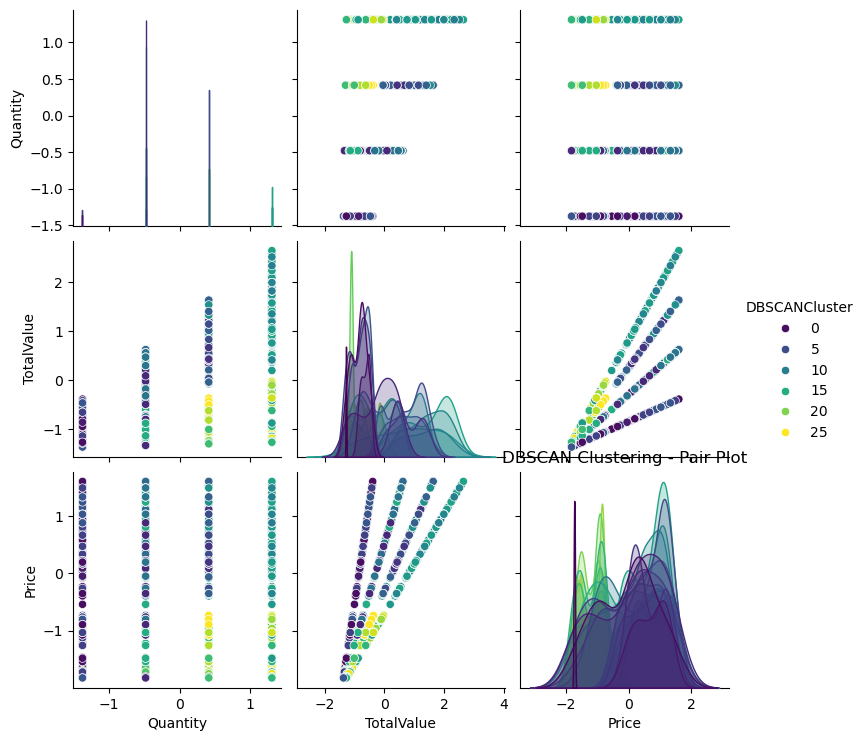

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize clusters using pairplot
sns.pairplot(scaled_df, vars=["Quantity", "TotalValue", "Price"], hue="DBSCANCluster", palette="viridis")
plt.title("DBSCAN Clustering - Pair Plot")
plt.show()


- The pair plot illustrates the distribution of clusters generated by DBSCAN using the features **Quantity**, **TotalValue**, and **Price**.

#### Cluster Insights
##### Cluster 0 (Low Value):
- Represent customers with low **Quantity**, **TotalValue**, and **Price**.
- Likely budget-conscious or infrequent buyers.
##### Clusters 5, 15, and 25 (High Value):
- Customers in these clusters are associated with higher spending (**TotalValue**) and moderate-to-high **Price**.
- Represents high-value customers who might prefer premium products or bulk purchases.
##### Cluster 10 (Moderate Value):
- Positioned between low and high spenders.
- Customers in this cluster are likely occasional buyers of higher-priced items.
